# Predicting the NBA Regular Season MVP Winner


## Load data

In [1312]:
# import our usual libraries
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

In [300]:
# since we have many files, let's create function to read in and name the files
def importGlobbedFiles(path):
    globbed_files = glob.glob(path + '/*.csv')
    list_of_dfs = []
    for csv in globbed_files:
        df = pd.read_csv(csv)
        list_of_dfs.append(df)
    return pd.concat(list_of_dfs)

In [1267]:
# read in 3 datasets
df_basic = importGlobbedFiles('data_historical_basic_stats')
df_adv = importGlobbedFiles('data_historical_adv_stats')
df_mvp = importGlobbedFiles('data_historical_mvp')

## First pass preprocessing & EDA

In [1268]:
# check out the data
# df_basic.head()
# df_adv.head()
# df_mvp.head()
# df_basic.info()

We see some information is repeated in the basic and advanced data sets.

We need to assign MVP-caliber players appropriately. We consider MVP-caliber to be any player on the MVP shortlist to have received at least 1 first-place vote.

In [1270]:
# adjust feature names to lowercase and remove whitespace
def adjustFeatureNames(df):
    df.columns = df.columns.str.lower().str.replace(' ', '_')

# there are some * associated with player names. this function will remove them
def cleanSomeFeatures(df):
    df['player'] = df['player'].str.replace('*','')
    
for df in [df_basic, df_adv, df_mvp]:
    adjustFeatureNames(df)
    cleanSomeFeatures(df)

At this point we've decided to merge the selected dataframes together based on the original EDA.

In [1592]:
# make a copy of df_mvp
df_mvp_prep = df_mvp.copy()

# add new feature to signify which players were on the mvp shortlist
df_mvp_prep['mvp_caliber'] = 1

# add new feature to signify which player in the shortlist won mvp
df_mvp_tmp = df_mvp_prep.groupby('mvp_year').max()[['share']].reset_index()
df_mvp_tmp['mvp'] = 1
df_mvp_prep = df_mvp_prep.merge(df_mvp_tmp, how='outer', on=['mvp_year', 'share'])

# combine all dataframes: basic, advanced, mvp
basic_features = ['player', 'tm', 'season_end',  'g', 'gs', 'mp', 'fg', 'fga', 'fg%'
                  , '3p', '3pa', '3p%', '2p', '2pa', '2p%', 'efg%', 'ft', 'fta', 'ft%'
                  , 'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']
adv_features = ['player', 'tm', 'season_end', 'per', 'ts%', '3par', 'ftr', 'orb%'
                , 'drb%', 'trb%', 'ast%', 'stl%', 'blk%', 'tov%', 'usg%', 'ows'
                , 'dws', 'ws', 'ws/48', 'obpm', 'dbpm', 'bpm', 'vorp']
mvp_features = ['player', 'tm', 'mvp_year', 'share', 'mvp_caliber', 'mvp']

# first merge: basic + adv
df_basic_adv_tmp = df_basic[basic_features].merge(df_adv[adv_features]
                                                  , how='left', on=['player', 'tm', 'season_end'])

# second merge: basic-adv + mvp
df_all_stats = df_basic_adv_tmp.merge(df_mvp_prep[mvp_features]
                                      , how='left' , left_on=['player', 'tm', 'season_end']
                                      , right_on=['player', 'tm', 'mvp_year'])

# fill NaN with 0
df_all_stats.fillna(0, inplace=True)

In [1707]:
df_all_stats.columns

Index(['player', 'tm', 'season_end', 'g', 'gs', 'mp', 'fg', 'fga', 'fg%', '3p',
       '3pa', '3p%', '2p', '2pa', '2p%', 'efg%', 'ft', 'fta', 'ft%', 'orb',
       'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 'per', 'ts%',
       '3par', 'ftr', 'orb%', 'drb%', 'trb%', 'ast%', 'stl%', 'blk%', 'tov%',
       'usg%', 'ows', 'dws', 'ws', 'ws/48', 'obpm', 'dbpm', 'bpm', 'vorp',
       'mvp_year', 'share', 'mvp_caliber', 'mvp'],
      dtype='object')

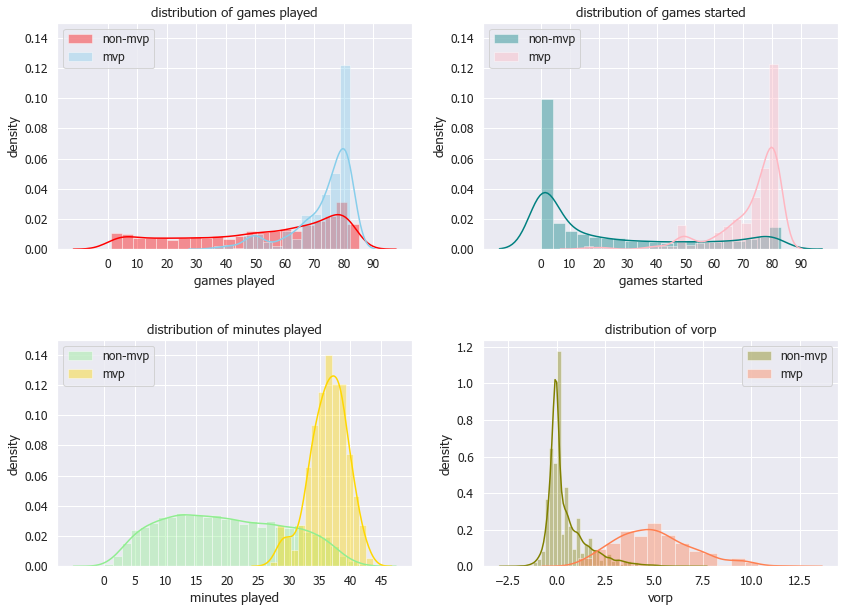

In [1719]:
from matplotlib.gridspec import GridSpec

# set style
sns.set(style='darkgrid', font='Tahoma', font_scale=1.1)

# we want to compare the distribution of key attributes of mvp-caliber players and not
mvp_g = np.array(df_all_stats.query('mvp_caliber == 1')['g'])
mvp_mp = np.array(df_all_stats.query('mvp_caliber == 1')['mp'])
non_mvp_g = np.array(df_all_stats.query('mvp_caliber == 0')['g'])
non_mvp_mp = np.array(df_all_stats.query('mvp_caliber == 0')['mp'])
mvp_gs = np.array(df_all_stats.query('mvp_caliber == 1')['gs'])
non_mvp_gs = np.array(df_all_stats.query('mvp_caliber == 0')['gs'])
mvp_vorp = np.array(df_all_stats.query('mvp_caliber == 1')['vorp'])
non_mvp_vorp = np.array(df_all_stats.query('mvp_caliber == 0')['vorp'])

# set gridspect to be 2 x 2
fig = plt.figure(figsize=(14,10))
gs = GridSpec(nrows=2, ncols=2, hspace=0.4)

# add plot for games played
ax1 = fig.add_subplot(gs[0,0])
ax1 = sns.distplot(non_mvp_g, hist=True, kde = True, color='red', label='non-mvp')
ax1 = sns.distplot(mvp_g, hist=True, kde=True, color='skyblue', label='mvp')
ax1.set_title('distribution of games played')
ax1.set_xlabel('games played')
ax1.set_ylabel('density')
ax1.set_ylim(0, 0.150)
ax1.set_xticks(np.arange(0, 100, step=10))
ax1.legend()

# add plot for minutes played
ax2 = fig.add_subplot(gs[1,0])
ax2 = sns.distplot(non_mvp_mp, hist=True, kde = True, color='lightgreen', label='non-mvp')
ax2 = sns.distplot(mvp_mp, hist=True, kde=True, color='gold', label='mvp')
ax2.set_title('distribution of minutes played')
ax2.set_xlabel('minutes played')
ax2.set_ylabel('density')
ax2.set_ylim(0, 0.150)
ax2.set_xticks(np.arange(0, 50, step=5))
ax2.legend()

# add plot for games started
ax3 = fig.add_subplot(gs[0,1])
ax3 = sns.distplot(non_mvp_gs, hist=True, kde = True, color='teal', label='non-mvp')
ax3 = sns.distplot(mvp_gs, hist=True, kde=True, color='lightpink', label='mvp')
ax3.set_title('distribution of games started')
ax3.set_xlabel('games started')
ax3.set_ylabel('density')
ax3.set_ylim(0, 0.150)
ax3.set_xticks(np.arange(0, 100, step=10))
ax3.legend()

# add plot for vorp
ax3 = fig.add_subplot(gs[1,1])
ax3 = sns.distplot(non_mvp_vorp, hist=True, kde = True, color='olive', label='non-mvp')
ax3 = sns.distplot(mvp_vorp, hist=True, kde=True, color='coral', label='mvp')
ax3.set_title('distribution of vorp')
ax3.set_xlabel('vorp')
ax3.set_ylabel('density')
# ax3.set_ylim(0, 0.150)
# ax3.set_xticks(np.arange(0, 100, step=10))
ax3.legend()

plt.show();

At this point we will pare down the players. Since we are trying to determine the MVP-caliber players, we do not need to consider players who will probably never be voted MVP.

In [1451]:
# include only players who have played > 40 games
# & have played more than 20 minutes
df_all_stats2 = df_all_stats[(df_all_stats['g'] > 41)
                             & (df_all_stats['mp'] > 25)
                             & (df_all_stats['pts'] > 5)].reset_index(drop=True)

In [1492]:
# if we just guessed:
accuracy_to_beat = 1-len(df_all_stats2.query('mvp_caliber == 1'))/len(df_all_stats2)
print('this is the accuracy to beat: {:.2%}'.format(accuracy_to_beat))

this is the accuracy to beat: 90.11%


## 3. Split into train & test sets

At this stage, the final dataframe is ready. Dtypes are appropriate, missing values have been taken care of. The features and target variable have been identified.

- One-hot encoded categorical variables
- Split data into features and labels
- Converted to arrays
- Split data into training and testing sets

In [1455]:
# to implement a pipeline, we separate the features and target variable first

features = df_all_stats2.iloc[:,3:-4].reset_index(drop=True) # this is a dataframe class
target_variable = df_all_stats2.iloc[:,-2:-1].to_numpy().ravel() # this is a 1D array
feature_names = features.columns.to_numpy() # this is an array

# let's change these dataframe types to arrays

# X = features.to_numpy() # this is a 2D array
# y = target_variable.to_numpy().ravel() # this is a 1D array

In [1582]:
# split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target_variable
                                                    , random_state=42
                                                    , test_size = 0.3
                                                    , stratify=target_variable)
print('shape of training set features: ', X_train.shape)
print('shape of target variable: ', y_train.shape)
print('shape of test set features: ', X_test.shape)
print('shape of target variable: ', y_test.shape)

shape of training set features:  (2292, 18)
shape of target variable:  (2292,)
shape of test set features:  (983, 18)
shape of target variable:  (983,)


In [1458]:
# test that stratify worked

In [1572]:
# baseline
train_mvp_caliber_count = np.count_nonzero(y_train)
train_count = len(y_train)

print('count of mvp_caliber in train: ', train_mvp_caliber_count)
print('count of train: ', train_count)
print('baseline accuracy in train set: {:.2%}'.format(1-train_mvp_caliber_count/train_count))
print('\n')

test_mvp_caliber_count = np.count_nonzero(y_test)
test_count = len(y_test)

print('count of mvp_caliber in test: ', test_mvp_caliber_count)
print('count of test: ', test_count)
print('baseline accuracy in test set: {:.2%}'.format(1-test_mvp_caliber_count/test_count))

count of mvp_caliber in train:  227
count of train:  2292
baseline accuracy in train set: 90.10%


count of mvp_caliber in test:  97
count of test:  983
baseline accuracy in test set: 90.13%


## 4. Preprocess the data for machine learning

### Feature selection

Which features are best? Choose only a few to avoid overfitting and the curse of dimensionality.

We use several methods here:
- univariate feature selection: in this case, the ANOVA F-value
- recursive feature elimination (RFE)
- feature importance from decision trees classifier
- ridge regression
- principle component analysis (PCA)

In [1480]:
# univariate feature selection

from sklearn.feature_selection import SelectKBest, f_classif

# since X is numerical data and y is labeled, we should use the ANOVA F-value (f_classif)

selector = SelectKBest(f_classif, k=4)
X_train_fitted = selector.fit_transform(X_train, y_train)
print('F-value scores: %s' % selector.scores_)
print('Feature index: %s' % selector.get_support(indices=True))
print('Feature names: %s' % feature_names[selector.get_support(indices=True)])

F-value scores: [   6.399   96.746  358.483   44.339   20.75    98.192  257.752  175.635
   45.159  426.081    1.88   815.148 1035.014   77.599  516.325  713.743
 1107.273 1402.982]
Feature index: [11 12 16 17]
Feature names: ['pts' 'per' 'bpm' 'vorp']


In [1481]:
# recursive feature elimination. chose Logistic Regression, but can use other estimators

from sklearn.feature_selection import RFE

model = RandomForestClassifier(n_estimators=500)
rfe = RFE(model, n_features_to_select=4)
fit = rfe.fit(X_train, y_train)
print('Feature ranking: %s' % fit.ranking_)
print('Feature index ranked #1: %s' % fit.get_support(indices=True))
print('Feature names: %s' % feature_names[fit.get_support(indices=True)])

Feature ranking: [14 15  6 11 10  8  7 12 13  4  9  1  1  5  3  2  1  1]
Feature index ranked #1: [11 12 16 17]
Feature names: ['pts' 'per' 'bpm' 'vorp']


In [1580]:
# feature importance using ensemble learning
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier(n_estimators=500)
model.fit(X_train, y_train)
important_features = pd.Series(data=model.feature_importances_, index=feature_names)
print(important_features.sort_values(ascending=False)) # show top 4 only

vorp     0.123149
bpm      0.115435
per      0.108888
ws/48    0.091099
pts      0.086466
usg%     0.064915
tov      0.054844
mp       0.050747
ast      0.042549
stl      0.035236
trb      0.032010
ts%      0.030598
pf       0.029804
blk      0.029550
fg%      0.027298
efg%     0.026678
gs       0.025795
g        0.024937
dtype: float64
0.9999999999999998


In [1431]:
# PCA
# from sklearn.decomposition import PCA

# pca = PCA(n_components=4)
# fit = pca.fit(X_train)
# print('Explained Variance: %s' % fit.explained_variance_ratio_)
# pd.DataFrame(pca.components_, columns=feature_names, index=['PC-1', 'PC-2', 'PC-3', 'PC-4'])

In [1462]:
# ridge regression
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

def show_coefs(ridge_coefficients): 
    names = ['x%s' % i for i in range(len(ridge_coefficients))]
    lst = list(zip(names, feature_names, np.round(ridge_coefficients,3)))
    return lst

print(show_coefs(ridge.coef_))

[('x0', 'g', -0.003), ('x1', 'gs', 0.0), ('x2', 'mp', -0.024), ('x3', 'fg%', 0.13), ('x4', 'efg%', -0.351), ('x5', 'trb', 0.006), ('x6', 'ast', 0.004), ('x7', 'stl', -0.007), ('x8', 'blk', 0.029), ('x9', 'tov', 0.06), ('x10', 'pf', -0.039), ('x11', 'pts', 0.034), ('x12', 'per', -0.006), ('x13', 'ts%', -0.796), ('x14', 'usg%', -0.014), ('x15', 'ws/48', 0.875), ('x16', 'bpm', -0.066), ('x17', 'vorp', 0.17)]


### 5c. Feature scaling

Once features are chosen, let's scale the data.

Normalize or standardize data.
- min-max scaling/normalization = x-min/(max-min) <- value between (0,1)
- standardization = x-mean/sd <- standardized values always have 0 mean. less affected by outliers.

In [1504]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(data=X_train_scaled, columns=feature_names) # index has been reset

We choose these features in our dataset:

In [1505]:
X_train_ML = X_train_scaled[['vorp', 'per', 'ws/48', 'bpm']]

In [1507]:
print(len(X_train_ML))
print(len(y_train))

2292
2292


## 6. Train a model

Train & evaluate on the training set.
Then use cross-validation.

In [1508]:
# because this is an unbalanced dataset:

total_short_list = np.count_nonzero(y_train == 1)
total_players = len(X_train_ML)
print('we need to beat this accuracy: {:.2%}'.format((1-total_short_list/total_players)))

we need to beat this accuracy: 90.10%


In [1509]:
# create function
from sklearn.pipeline import make_pipeline

def modelClf(clf):
    pipe = make_pipeline(MinMaxScaler(), clf)
    pipe.fit(X_train_ML, y_train)
    return pipe.score(X_train_ML, y_train)

In [1510]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier

In [1511]:
# Logistic Regression
log_reg_score = modelClf(LogisticRegression(solver='lbfgs'))
print('logistic regression labeling accuracy: {:.2%}'.format(log_reg_score))

# Random Forest
rf_score = modelClf(RandomForestClassifier(n_estimators=500))
print('random forest labeling accuracy: {:.2%}'.format(rf_score))

# SVC
svc_score = modelClf(SVC(gamma='scale'))
print('svc labeling accuracy: {:.2%}'.format(svc_score))

# KNN
knn_score = modelClf(KNeighborsClassifier())
print('knn labeling accuracy: {:.2%}'.format(knn_score))

logistic regression labeling accuracy: 94.02%
random forest labeling accuracy: 100.00%
svc labeling accuracy: 94.24%
knn labeling accuracy: 94.85%


In [1512]:
# create function
from sklearn.pipeline import make_pipeline

def modelClf2(clf):
    pipe = make_pipeline(MinMaxScaler(), clf)
    pipe.fit(X_test, y_test)
    return pipe.score(X_test, y_test)

In [1513]:
# Logistic Regression
log_reg_score = modelClf2(LogisticRegression(solver='lbfgs'))
print('logistic regression labeling accuracy: {:.2%}'.format(log_reg_score))

# Random Forest
rf_score = modelClf2(RandomForestClassifier(n_estimators=500))
print('random forest labeling accuracy: {:.2%}'.format(rf_score))

logistic regression labeling accuracy: 95.12%
random forest labeling accuracy: 100.00%


### 7b. Cross validation

In [1539]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC, LinearSVC

def display_scores(scores):
    print(f'scores: {scores}')
    print('mean & (std): {:.3%}'.format(np.mean(scores)))
#     print(f'mean & (std): {:.3%} (+/- {:.3%})'.format(np.mean(scores), np.std(scores)*2))
    
clf1 = SVC(kernel='linear', C=1)
scores1 = cross_val_score(clf1, X_train_ML, y_train, cv=5, scoring='accuracy')
display_scores(scores1)

recall = cross_val_score(clf1, X_train_ML, y_train, cv=5, scoring='recall')
print('Recall', np.mean(recall), recall)
precision = cross_val_score(clf1, X_train_ML, y_train, cv=5, scoring='precision')
print('Precision', np.mean(precision), precision)
f1 = cross_val_score(clf1, X_train_ML, y_train, cv=5, scoring='f1')
print('F1', np.mean(f1), f1)

rf = RandomForestClassifier(1000)
scores2 = cross_val_score(rf, X_train_ML, y_train, cv=5)
print(scores2)
display_scores(scores2)

clf3 = LogisticRegression(solver='lbfgs')
scores3 = cross_val_score(clf3, X_train_ML, y_train, cv=5)
display_scores(scores3)

clf4 = KNeighborsClassifier()
scores4 = cross_val_score(clf4, X_train_ML, y_train, cv=5)
display_scores(scores4)

scores: [0.935 0.937 0.937 0.93  0.952]
mean & (std): 93.805%
Recall 0.4757487922705314 [0.478 0.478 0.444 0.422 0.556]
Precision 0.823957671957672 [0.786 0.815 0.833 0.76  0.926]
F1 0.602869210570223 [0.595 0.603 0.58  0.543 0.694]
[0.941 0.932 0.926 0.932 0.959]
scores: [0.941 0.932 0.926 0.932 0.959]
mean & (std): 93.805%
scores: [0.935 0.935 0.934 0.934 0.95 ]
mean & (std): 93.761%
scores: [0.928 0.93  0.924 0.937 0.939]
mean & (std): 93.150%


In [1542]:
print('Parameters currently in use:\n')
print(rf.get_params())

Parameters currently in use:

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1000, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


## Fine tune your model & evaluate on the test set

- grid search vs. randomized search
- ensemble methods

In [1543]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [1545]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid
                               , n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_ML, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.3min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [1548]:
rf_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': True}

In [1552]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy

base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(X_train_ML, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

ValueError: Number of features of the model must match the input. Model n_features is 4 and input n_features is 18 

## Present the solution